In [37]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

In [38]:
df = pd.read_csv("data/rotten_tomatoes_movies.csv").drop(['id', 'boxOffice'], axis=1).drop_duplicates()
print(df.shape)
df.sample(5).T

(141696, 14)


,40846,102990,87582,33954,118306
title,"Mi niño, mi caballo y yo",After the Life,Realm of the Ancient Redwoods,Legends of Oz: Dorothy's Return,Endgame
audienceScore,NaN,77.0,NaN,68.0,58.0
tomatoMeter,NaN,91.0,NaN,16.0,71.0
rating,NaN,NaN,NaN,PG,PG-13
ratingContents,NaN,NaN,NaN,"['Some Scary Images', 'Mild Peril']","['Disturbing Images', 'Violence', 'Some Strong..."
releaseDateTheaters,NaN,2004-01-01,NaN,2014-05-09,2009-11-06
releaseDateStreaming,NaN,NaN,NaN,2014-08-26,2009-12-01
runtimeMinutes,88.0,120.0,53.0,91.0,109.0
genre,Comedy,"Crime, Drama",Documentary,"Kids & family, Musical, Fantasy, Adventure, An...",Drama
originalLanguage,Spanish,French (Canada),NaN,English,English


In [39]:
# select main and extra labels
df = df.rename(columns = {'audienceScore':'voters_rating', 'tomatoMeter': 'critics_rating'})
main_label = 'voters_rating'
extra_label = 'critics_rating'
df = df[(~df[main_label].isnull())&(~df[extra_label].isnull())]

# convert releaseDateTheaters to decade
def transform_release_date(x):
    try:
        return str(int(re.search("(\d{4})", x).group(0))//10)+'0s'
    except:
        return 'None'
df['releaseDateTheaters'] = df['releaseDateTheaters'].apply(transform_release_date)
# convert runtime
def transform_runtime(x):
    try:
        return str(20*round(1/20*int(x)))
    except:
        return 'None'
df['runtimeMinutes'] = df['runtimeMinutes'].apply(transform_runtime)
# Preprocess genre, director, and soundMix columns
def vectorize_column(df, col='genre'):
    ll = df[col].fillna('None').str.split(', ').to_list()
    ll = [' '.join([i.replace('\'', '_').replace('&', '_').replace('.', '_').replace('-', '_').replace(' ', '_').replace('+', '_') for i in item]) for item in ll]
    vectorizer = CountVectorizer(min_df=25, lowercase=False)
    vectorizer.fit(ll)
    voc = vectorizer.vocabulary_
    voc_inv = {v: col+'_'+k for k, v in voc.items()}
    vector = vectorizer.transform(ll)
    tt = pd.DataFrame(vector.toarray())
    tt = tt.rename(columns=voc_inv)
    df = pd.concat([df.reset_index(drop=True),tt.reset_index(drop=True)], axis=1).drop([col], axis=1)
    return df
df = vectorize_column(df)
# drop unused columns
cols2drop = ['title', 'writer', 'soundMix', 'originalLanguage', 'releaseDateStreaming', 'ratingContents', 'director']
df = df.drop(cols2drop, axis=1)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['rating', 'distributor', 'releaseDateTheaters', 'runtimeMinutes']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=60, replace_with='Other', tol=100/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
df.shape

(30052, 30)

In [40]:
df.sample(5).T

,25208,7314,2212,18545,26215
voters_rating,91.0,65.0,38.0,42.0,64.0
critics_rating,82.0,50.0,50.0,100.0,82.0
rating,None,None,None,R,None
releaseDateTheaters,None,1990s,None,None,1960s
runtimeMinutes,100,100,80,120,160
distributor,None,None,None,None,Warner Bros. Pictures
genre_Action,0,0,0,0,0
genre_Adventure,0,0,0,0,0
genre_Animation,0,0,0,0,0
genre_Anime,0,0,0,0,0


In [41]:
# initialize data

y = df.dropna()[main_label].values.reshape(-1,)
X = df.dropna().drop([main_label]+[extra_label], axis=1) # drop extra labels
cat_cols = X.select_dtypes(include=['object']).columns
print(cat_cols)
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=83)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Index(['rating', 'releaseDateTheaters', 'runtimeMinutes', 'distributor'], dtype='object')


((15026, 28), (15026, 28), (15026,), (15026,))

In [42]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=1000,
                          depth=4, 
                          learning_rate=0.05,
                          verbose=0,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,2)} percentage points, and for test {round(rmse_test,2)} percentage points")

RMSE score for train 17.75 percentage points, and for test 18.25 percentage points


In [43]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,2)} percentage points, and for test {round(rmse_bs_test,2)} percentage points")

RMSE baseline score for train 20.87 percentage points, and for test 20.86 percentage points


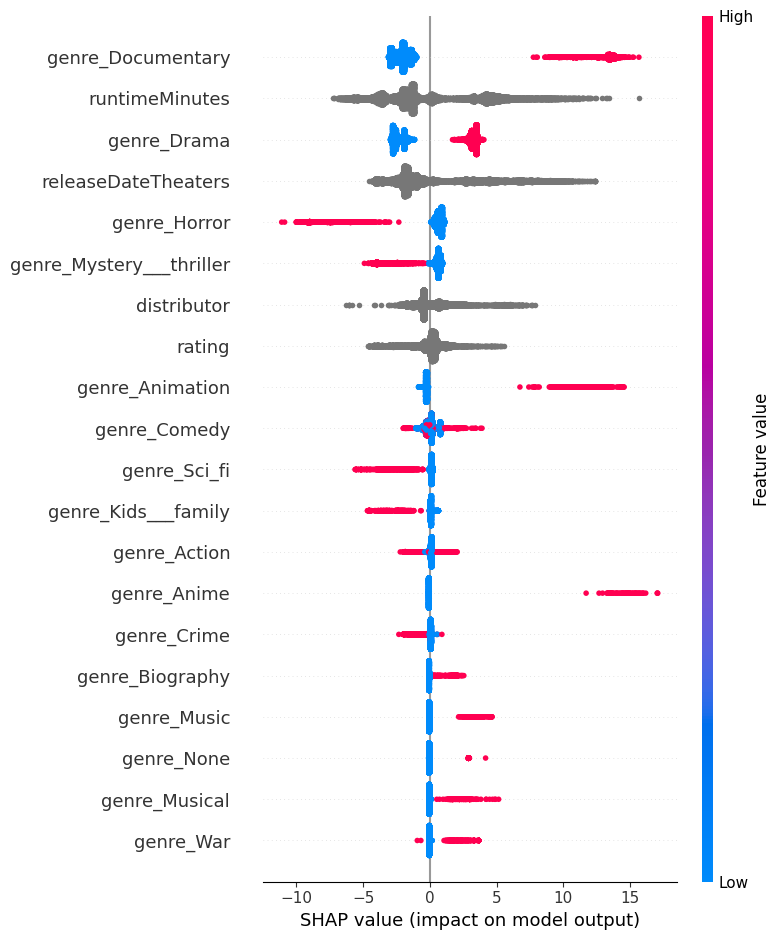

In [44]:
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=20)

In [45]:
def show_shap0(col, shap_values=shap_values, label=main_label, X_test=X_test):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,X_test.columns.tolist().index(col)]
    gain = 0
    gain = df_infl.groupby(col).mean().loc[1, 'shap_']-df_infl.groupby(col).mean().loc[0, 'shap_']
    gain_std = ((df_infl.groupby(col).std().loc[1, 'shap_'])**2+(df_infl.groupby(col).std().loc[0, 'shap_'])**2)**0.5
    return round(gain,3), round(gain_std,3)

def show_variants(start_str='genre', shap_values=shap_values, label=main_label, X_test=X_test):
    col_list = []
    gain_list = []
    gain_std_list = []
    for col in X_test.columns:
        if col.startswith(start_str+'_'):
            try:
                gain, gain_std = show_shap0(col, shap_values=shap_values, label=main_label, X_test=X_test)
                col_list.append(col.replace(start_str+'_',''))
                gain_list.append(gain)
                gain_std_list.append(gain_std)
            except:
                pass
    dd_dict = {'col': col_list, 'gain': gain_list, 'gain_std': gain_std_list}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(12,9))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for {start_str}, label {label}')
    plt.ylabel('Percentage points')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    return df_res

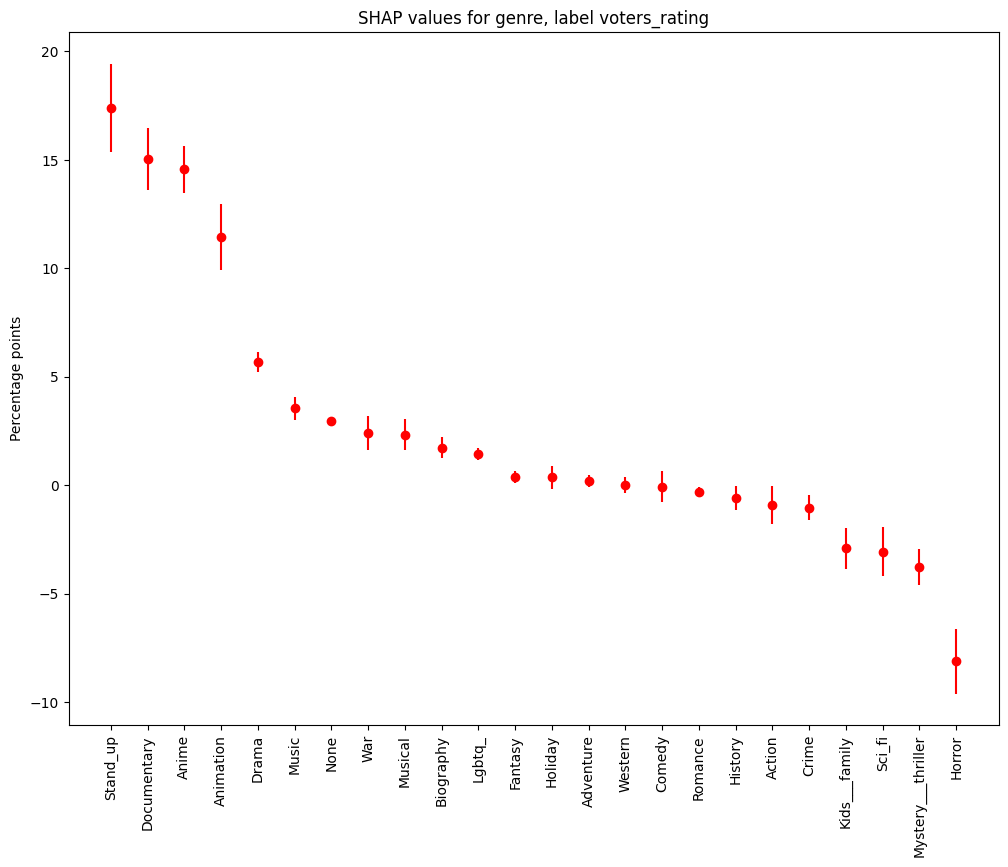

,gain,gain_std
col,,
Stand_up,17.404,2.030
Documentary,15.045,1.428
Anime,14.564,1.081
Animation,11.433,1.530
Drama,5.685,0.462
Music,3.532,0.534
None,2.951,0.080
War,2.401,0.784
Musical,2.331,0.703


In [46]:
show_variants('genre', shap_values=shap_values, label=main_label, X_test=X_test)